In [1]:
# added new env using these instructions: https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084

In [ ]:
# based on this tutorial: https://towardsdatascience.com/creating-beautiful-topography-maps-with-python-efced5507aa3


# download Global Multi-resolution Terrain Elevation Data 2010 (GMTED2010) mean 
# https://topotools.cr.usgs.gov/gmted_viewer/viewer.htm

In [2]:
import geopandas as gpd

In [3]:
import rasterio
import matplotlib.pyplot as plt

file = rasterio.open('data/30N000E_20101117_gmted_mea075.tiff')
dataset = file.read()
print(dataset.shape)

(1, 9600, 14400)


In [4]:
plt.rcParams["figure.figsize"] = (20,10)

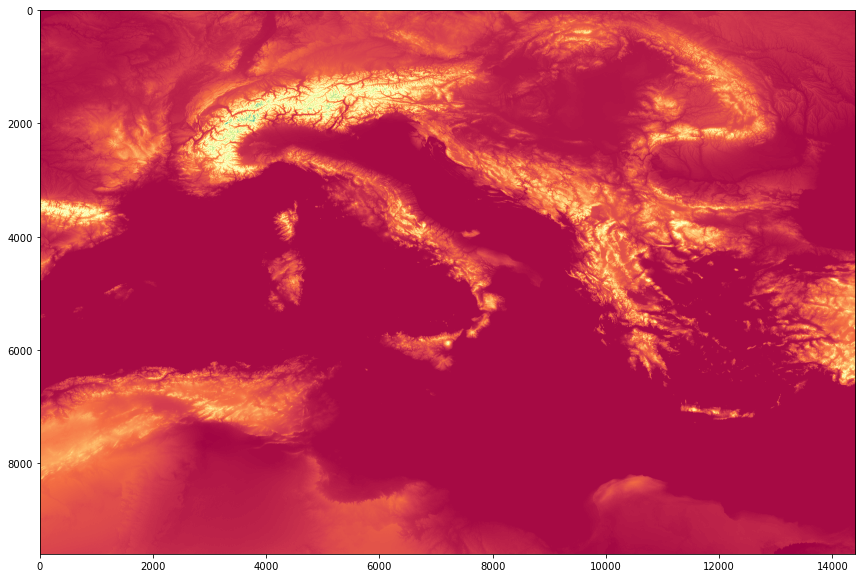

In [5]:
plt.imshow(dataset[0], cmap='Spectral')
plt.show()

| 0.00, 0.00, 6.60|
| 0.00,-0.00, 47.09|
| 0.00, 0.00, 1.00|


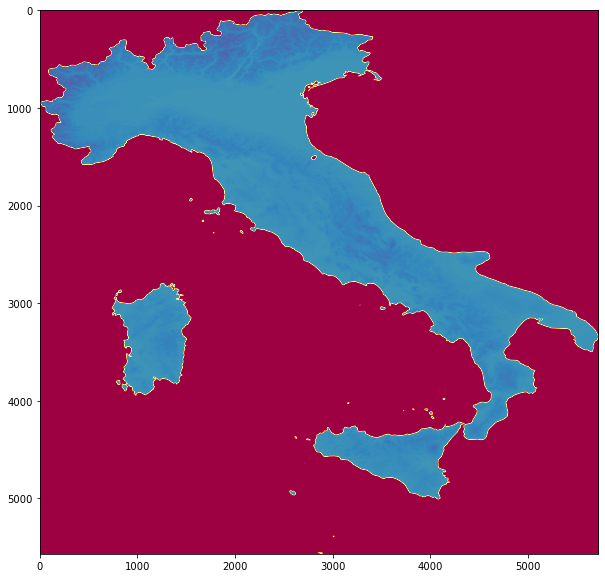

In [13]:
import geopandas as gpd
from shapely.geometry import mapping
from rasterio import mask as msk

# natural earth data from https://www.naturalearthdata.com/downloads/10m-cultural-vectors/

df = gpd.read_file('data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')

italy = df.loc[df['ADMIN'] == 'Italy']

clipped_array, clipped_transform = msk.mask(file, [mapping(italy.iloc[0].geometry)], crop=True)

print(clipped_transform)

plt.imshow(clipped_array[0], cmap='Spectral')
plt.show()

before 8
after 0


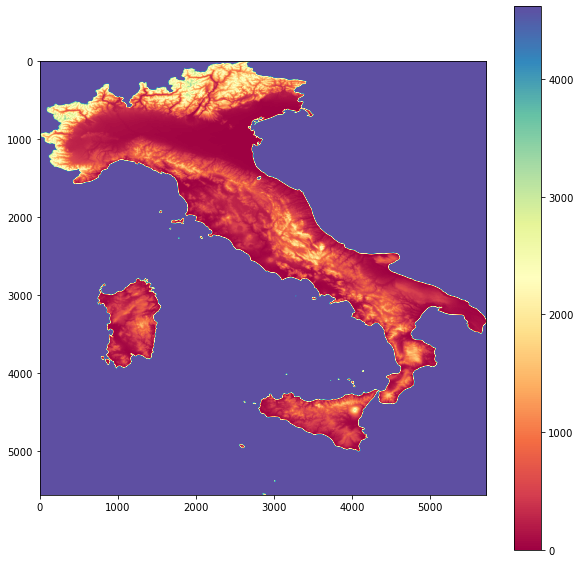

In [15]:
import numpy as np
from rasterio import mask as msk

def clip_raster(gdf, img):
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)], crop=True)
    clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)],
                                                           crop=True, nodata=(np.amax(clipped_array[0]) + 1))
    
    print('before', abs(np.amin(clipped_array)))
    clipped_array[0] = clipped_array[0] + abs(np.amin(clipped_array))
    print('after', abs(np.amin(clipped_array)))
    value_range = np.amax(clipped_array) + abs(np.amin(clipped_array))
    return clipped_array, value_range

italy_topography, value_range = clip_raster(italy, file)

plt.figure(figsize=(10,10))
c = plt.imshow(italy_topography[0], cmap='Spectral')
plt.colorbar(c)
plt.show()

In [37]:
value_range

4616

In [72]:
from matplotlib.colors import LinearSegmentedColormap
italy_colormap = LinearSegmentedColormap.from_list('italy',
                            ['#008C45','#F4F5F0','#cf2a32', '#CD212A', '#ff0000'], N=value_range)

from matplotlib.colors import ListedColormap

background_color = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors = italy_colormap(np.linspace(0, 1, value_range + 1))
newcolors = np.vstack((newcolors, background_color))
italy_colormap2 = ListedColormap(newcolors)

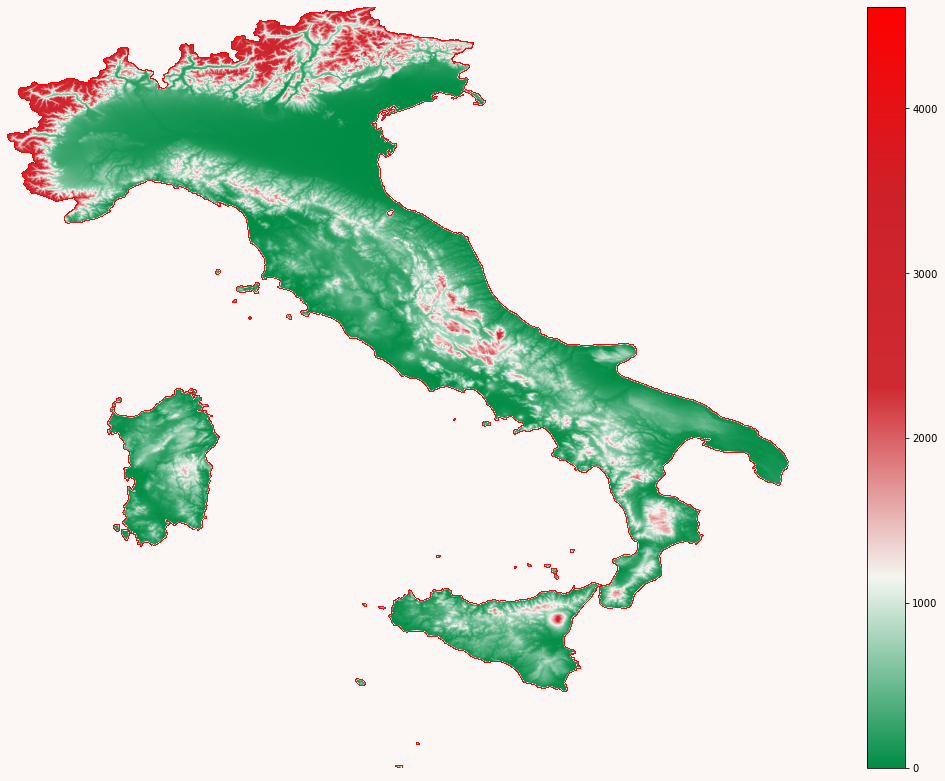

In [73]:
from matplotlib import colors

fig = plt.figure(facecolor='#FCF6F5FF')
fig.set_size_inches(28, 14)
ax = plt.axes()
plt.imshow(italy_topography[0], cmap=italy_colormap2)
ax.axis('off')
plt.colorbar()

plt.show()

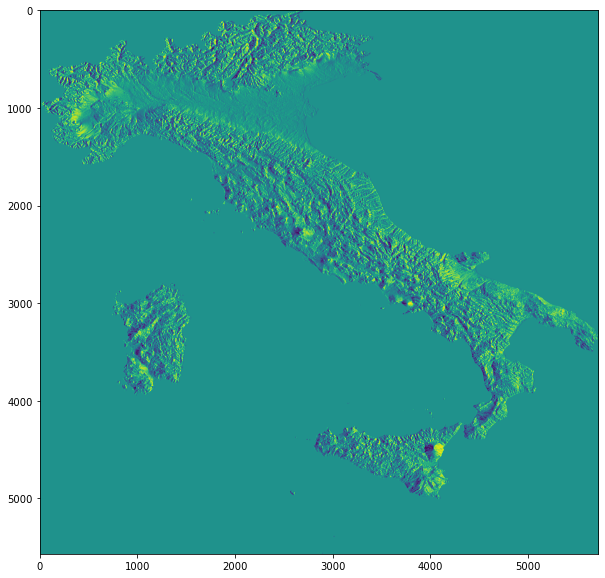

In [84]:
import earthpy.spatial as es

hillshade = es.hillshade(italy_topography[0], azimuth=90, altitude=1)

plt.imshow(hillshade)

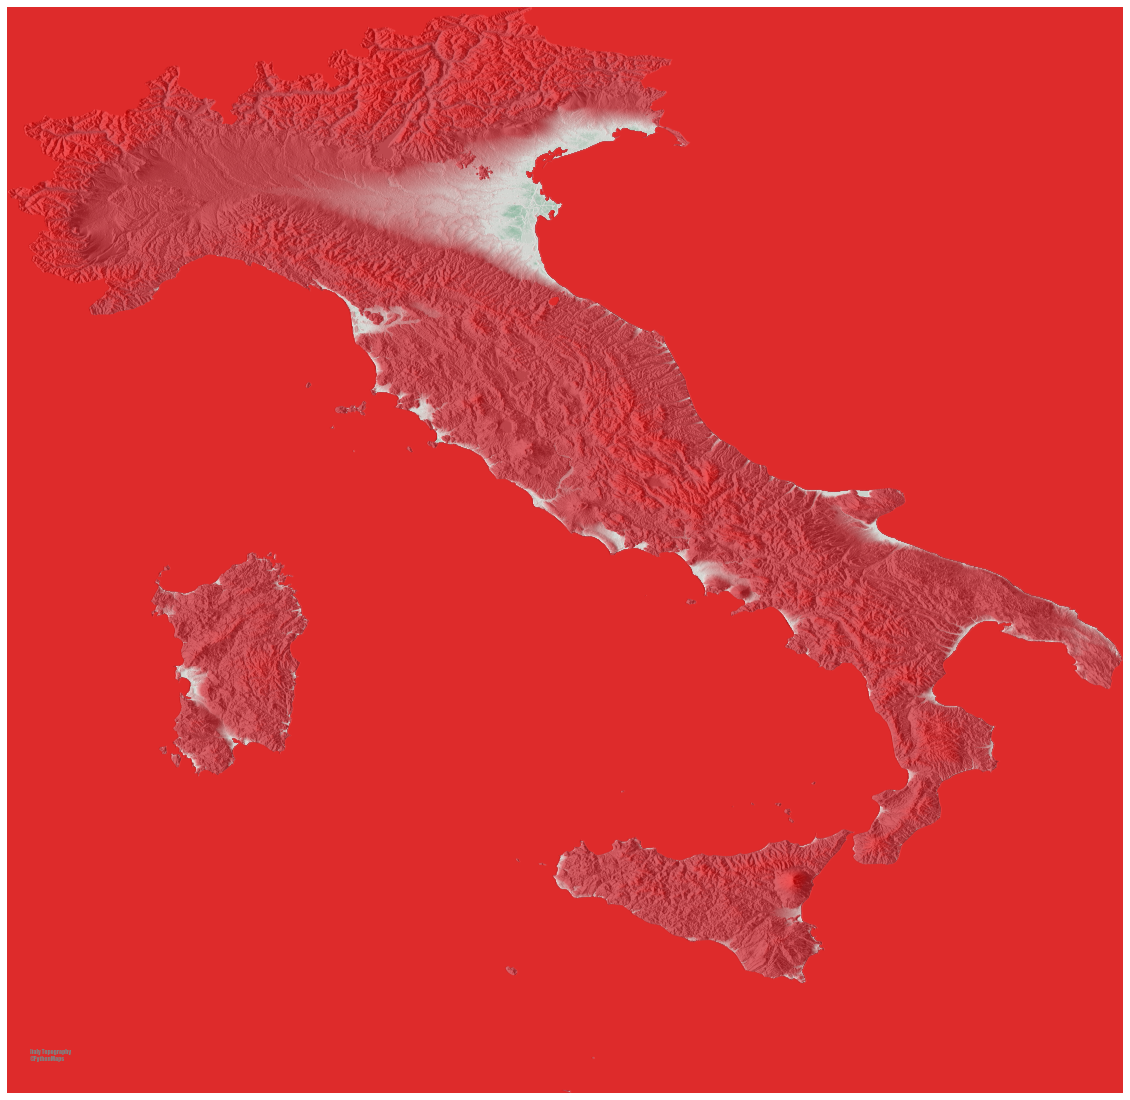

In [87]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
i = plt.imshow(italy_topography[0], cmap=italy_colormap, norm=colors.LogNorm())
ax.imshow(hillshade, cmap="Greys", alpha=0.3)
ax.axis('off')

#logo = plt.imread('../../globe.png')
newax = fig.add_axes([0.79, 0.78, 0.08, 0.08], anchor='NE')
#newax.imshow(logo)
newax.axis('off')
txt = ax.text(0.02, 0.03, "Italy Topography \n@PythonMaps",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')
plt.show()